# Eval the models trained on our dataset
`publish` them first so we don't have to worry about the model class.

In [1]:
import sys
from pathlib import Path
from ppi.main import publish

In [2]:
model_dir = Path('/home/quirin/PYTHON/ppi/runs/full/fft4')

In [3]:
publish(['/home/quirin/PYTHON/ppi/ppi/out/f9'])

100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


In [4]:
publish([model_dir])

100%|██████████| 46/46 [00:06<00:00,  7.19it/s]


In [5]:
publish([model_dir.with_stem('chimera')])

100%|██████████| 86/86 [00:10<00:00,  8.09it/s]


In [6]:
publish([model_dir.parent / 'fft3/chk_eval_339682.tar'])

100%|██████████| 1/1 [00:00<00:00,  7.92it/s]


on the server
>ppi publish --model /mnt/project/kaindl/ppi/runs/full/chimera
>ppi publish --model /mnt/project/kaindl/ppi/runs/full/fft4
>ppi publish --model /mnt/project/kaindl/ppi/runs/full/fft3/chk_eval_339682.tar

## Fetch some results

In [3]:
# download the full runs except for the large tboard folder and all checkpoints
!rsync -i -zar --bwlimit=51200 --exclude="*.log" --exclude="*.tar" --exclude="tboard" -e ssh "kaindl@rostssh:/mnt/project/kaindl/ppi/runs/full" "/home/quirin/PYTHON/ppi/runs"  --dry-run
'done'

'done'

In [ ]:
# download the full folders
!rsync -i -zar --bwlimit=51200 --exclude="*.log" -e ssh "kaindl@rostssh:/mnt/project/kaindl/ppi/runs/full/fft4" "/home/quirin/PYTHON/ppi/runs/full" --dry-run
!rsync -i -zar --bwlimit=51200 --exclude="*.log" -e ssh "kaindl@rostssh:/mnt/project/kaindl/ppi/runs/full/chimera" "/home/quirin/PYTHON/ppi/runs/full" --dry-run
'done'

In [8]:
# and the tensorboard
!mkdir "/home/quirin/PYTHON/ppi/runs/full/tboard/"
!rsync -i -zar --bwlimit=51200 --exclude="*.log" -e ssh "kaindl@rostssh:/mnt/project/kaindl/ppi/runs/full/tboard/fft4" "/home/quirin/PYTHON/ppi/runs/full/tboard" --dry-run
!rsync -i -zar --bwlimit=51200 --exclude="*.log" -e ssh "kaindl@rostssh:/mnt/project/kaindl/ppi/runs/full/tboard/chimera" "/home/quirin/PYTHON/ppi/runs/full/tboard" --dry-run
'done'

mkdir: cannot create directory ‘/home/quirin/PYTHON/ppi/runs/full/tboard/’: File exists


'done'

## Resume FFT4 xD

```yaml

io:
    outputOverwriteFile: /mnt/project/kaindl/ppi/runs/full/fft42_stdout.log
    errorOverwriteFile:  /mnt/project/kaindl/ppi/runs/full/fft42_stderr.log
    cwd: /mnt/project/kaindl/ppi/runs/full
limit:
    coreLimit: 80
    runtimeLimit: 336:00
    memLimit: 160GB!
resource:
    gpu: num=1/task:mode=shared:gmem=42G:j_exclusive=yes:gpack=yes
    # gpu: num=1:mode=exclusive_process:gmem=32G:j_exclusive=yes
    machines: lsf-server-2

notify:
    notifyJobDone: ""
    notifyJobExit:

properties:
    queueName: mid-end-normal
    jobName:   kaindl_fft42
command: >
  ppi resume
  --config fft4/config_fft4.json
  --checkpoint fft4/chk_3.tar
  --epochs 20
  --ppi-weight 10
  --name fft4
```

```shell
/mnt/project/kaindl/ppi/embed_data$ t5_utils extract-keys apid_huri.h5
```

In [3]:
from Bio import SeqIO
from tqdm import tqdm
from ppi_utils.general import to_fasta

In [36]:
proj_root = Path('/home/quirin/PYTHON/ppi/')

In [48]:
# extract the sequences we have to newly embed
!rsync -i -zar --bwlimit=51200 --exclude="*.log" -e ssh "kaindl@rostssh:/mnt/project/kaindl/ppi/embed_data/apid_huri_h5.keys" "/home/quirin/PYTHON/ppi/embed_data"
!sha256sum "/home/quirin/PYTHON/ppi/embed_data/apid_huri_h5.keys"

>f.st...... apid_huri_h5.keys
cc460ffa696d1cda84cdcd9448c8a246d7a569d6a61419666a1ea9513daf9ed5  /home/quirin/PYTHON/ppi/embed_data/apid_huri_h5.keys


In [51]:
with (proj_root / 'embed_data/apid_huri_h5.keys').open('r') as file:
    crcs = set(l.strip() for l in file)
sorted(crcs)[:10]

['CRC-000037AE195F7A9D',
 'CRC-000140D8BB91126A',
 'CRC-0004FA7836A741E8',
 'CRC-00050C5A816D1B06',
 'CRC-00053DA2C582D0E6',
 'CRC-000624825E507385',
 'CRC-0008B4CC2EF971CA',
 'CRC-00094EB0FBCA0E43',
 'CRC-00097529ECAB0123',
 'CRC-00099A7E52B3FC46']

In [52]:
dd = proj_root / 'ppi_data/v2/10:1_full'
seqs = dict()
for fasta in tqdm(set(dd.glob('*.fasta'))):
    seqs |= {r.id: str(r.seq) for r in SeqIO.parse(fasta, 'fasta')
             if r.id not in crcs}
len(seqs)

100%|██████████| 3/3 [00:00<00:00,  9.27it/s]


153

In [53]:
len(crcs)

62005

In [55]:
# write a fasta with the missing, unique cleaned-up original IDs
missing_fasta = proj_root / 'embed_data/missing.fasta'
with open(missing_fasta, 'w') as fasta:
    for _id in sorted(seqs.keys()):
        to_fasta(_id, seqs[_id], fasta)
!sha256sum $missing_fasta

7fa617b1702f012f62bfc339be713cd71e30fc4f719d6e03d33f9eed13e0cfe5  /home/quirin/PYTHON/ppi/embed_data/missing.fasta


make embeddings

```shell
cd /mnt/project/kaindl/ppi/embed_data
ppi embed --fasta missing.fasta --h5-file apid_huri.h5
```


## Pick a checkpoint

| model   |   step |   date | time  | exact            |
|---------|-------:|-------:|-------|------------------|
| fft3    | 339.7K |  1 Aug | 21:56 | chk_eval_339682  |
| fft4    |   435K |  4 Aug | 20:19 | chk_eval_435242  |
| fft4    |   817K | 11 Aug | 22:08 | chk_eval_817385  |
| chimera | 1.295M | 18 Aug | 05:30 | chk_eval_1295109 |
| chimera | 1.698M | 21 Aug | 20:09 | chk_7            |

In [6]:
publish([model_dir.parent / 'fft3/chk_eval_339682.tar'])

100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


In [40]:
checkpoints = ['fft3/chk_eval_339682.pt',
               'fft4/chk_eval_435242.pt',
               'fft4/chk_eval_817385.pt',
               'chimera/chk_eval_1295109.pt',
               'chimera/chk_7.pt']

## Re-plot the train progress

In [4]:
from pathlib import Path
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor, ceil

from t5.t5_utils import save

In [5]:
wd = Path('/home/quirin/PYTHON/ppi/eval')

dfs = list()
for csv in wd.glob('run-*.csv'):
    df = pd.read_csv(csv, header=0)
    df['cclass'] = csv.stem[csv.stem.find('-tag') - 2:][:2]
    dfs.append(df)
df = pd.concat(dfs)
df.head()

,Wall time,Step,Value,cclass
0,1.658725e+09,10616,0.099867,C1
1,1.658739e+09,21231,0.103036,C1
2,1.658753e+09,31846,0.106607,C1
3,1.658767e+09,42461,0.110471,C1
4,1.658781e+09,53076,0.112800,C1


In [6]:
df = df.loc[df['Wall time'] < 1.661e9].copy()
df.Step.max(), floor(1592342 * 2 / 15) * 4

(849230, 849248)

In [7]:
df['epoch'] = df.Step / df.Step.max() * 4
df = df.rename(columns=dict(Value='AUPR'))

In [8]:
sns.set_theme(style='ticks')
pal = dict(C0='#828282', C1='#D81B60', C2='#1E88E5', C3='#FFC107')

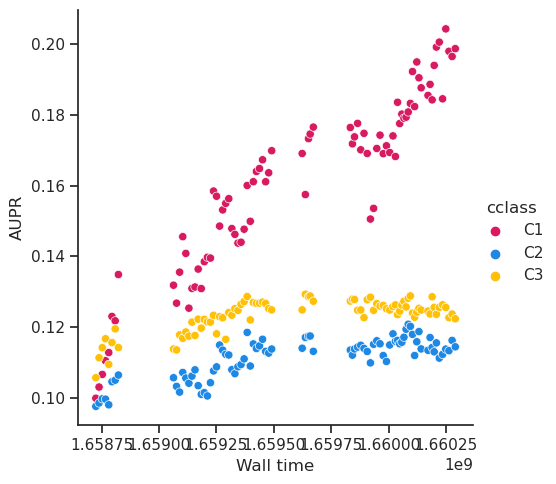

In [9]:
fig = sns.relplot(
    data=df,
    # kind='line',
    x='Wall time',
    y='AUPR',
    hue='cclass',
    palette=pal,
    lw=4,

)

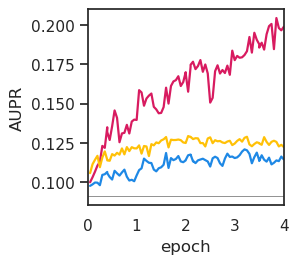

In [60]:
with mpl.rc_context({'figure.facecolor': 'none'}):
    fig = sns.relplot(
        data=df,
        kind='line',
        x='epoch',
        y='AUPR',
        hue='cclass',
        palette=pal,
        lw=1.6,
        height=3,
        legend=False,

    )
ax = fig.axes.flatten()[0]
ax.axhline(1 / 11, c='.5', lw=.6)
ax.set(box_aspect=1, xlim=(0, 4), xticks=range(5), xlabel='epoch')
plt.setp(ax.get_xticklines(), visible=False)
fig.despine(top=False, right=False)
# sns.move_legend(fig, 'center left',  bbox_to_anchor=(.8, .5), title=None)
save(fig, 'tb_aupr_curves_fft4', pdf=True)

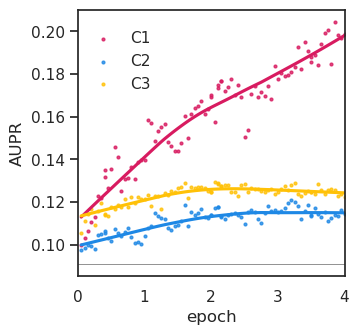

In [28]:

with mpl.rc_context({'figure.facecolor': 'none'}):
    # fig = sns.relplot(
    #     data=df,
    #     # kind='line',
    #     x='epoch',
    #     y='AUPR',
    #     hue='cclass',
    #     palette=pal,
    #     lw=4,
    #
    # )
    #
    # ax = fig.axes.flatten()[0]

    fig = sns.lmplot(
        data=df,
        x='epoch',
        y='AUPR',
        hue='cclass',
        palette=pal,
        lowess=True,
        # order=32,
        ci=None,
        # ax=ax,
        scatter_kws={'s': 4},
        height=3.8,
    )

ax = fig.axes.flatten()[0]
ax.set(box_aspect=1, xlim=(0, 4))

ax.axhline(1 / 11, c='.5', lw=.6)
ax.set(box_aspect=1, xlim=(0, 4), xticks=range(5))
plt.setp(ax.get_xticklines(), visible=False)

fig.despine(top=False, right=False)
fig.tight_layout()
sns.move_legend(fig, 'upper left',  bbox_to_anchor=(.18, .88), title=None)

In [139]:
1592341 / 15 * 2 * 4

849248.5333333333

In [146]:
ceil(1592341 / 15 * 2 * 4)

849249

In [ ]:
sns.set_theme(style='ticks')

with mpl.rc_context({'figure.facecolor': 'none'}):
    fig = sns.relplot(data=prs,
                      kind='line',
                      x='recall', y='precision',
                      color='#004D40',
                      # hue='species',
                      # palette={'human': '#004D40',
                      #          'train_counts': '#FFC107',
                      #          'proj_attention': '#DC267F',
                      #          },
                      # ax=ax,
                      height=2.8, aspect=1,
                      errorbar=None,
                      drawstyle='steps-post',  #linewidth=2.5,
                      )

    t = [0, .25, .5, .75, 1]
    tl = ['0', '.25', '.5', '.75', '1']

    fig.set(xlabel='recall', ylabel='precision',
            box_aspect=1,
            xticks=t, yticks=t,
            xticklabels=tl, yticklabels=tl)
    fig.tight_layout()

fig.despine(top=False, right=False)